## Kaggle Playground Series - March 2025 - Binary Prediction with a Rainfall Dataset
#### Thomas KLEIN

For my first time experimenting with a Kaggle playground series competition, I wanted to build a simple model and use a simple dataset, to apply skills I have learned in online courses on DataCamp, or even more recently, completing the Google Data Analytics certificate on Coursera. Therefore I recommend anyone wanting to apply skills learned from theoretical classes to try and play around with the Kaggle Playground Series.

This project will be a detailed presentation of the step by step analysis and model building as I am also planning to release as an explanatory article on my [portfolio blog](https://thomasklein90.github.io).

### 1. Project and introduction
#### 1.1. Data
The data is available on [Kaggle](https://www.kaggle.com/competitions/playground-series-s5e3/data?select=train.csv) as part of the March 2025 Kaggle Playground Series competition. We are provided with a sample csv file for submission (see 1.2. Objective), and a dataset already split between a 'train' (with the target metric) and a 'test' (without the target metric).The data consists of calendar and meteorological data. There is no extra information about what they mean exactly. Here are the 13 fields, with my best guess as to what they represent:

Variable  |Description |
-----|-----| 
id|Entry index|
day|Numbered from 1 to 365, day of the year|
pressure|Atmospheric pressure (from ~999 to ~1030) in mbar|
maxtemp|The maximum temperature of the day in Celsius|
temparature|The temperature of the day (maybe at time of recording)|
mintemp|The minimum temperature of the day in Celsius|
dewpoint|The dew point temperature, in Celsius, below which droplets begin to condense|
humidity|The percentage of humidity|
cloud|The percentage of cloud coverage in the sky|
sunshine|The numbers of hours of sunshine in the day|
winddirection|The direction of the wind (in degrees probably, although there are no values between 300 and 360)|
windspeed|The speed of the wind (in kph or mph, it is not known)|
rainfall|The binary target metric yes (0) or no (1)|

#### 1.2. Objective
The objective of the project and model is to predict whether or not there is rainfall for each day of the 'test' csv file. More specfically, we are to predict the probability of rain as well. This means that we will be looking to not only focus on the binary result (rainfall/no rainfall) but also on the probability in between 0 and 1. Therefore, we probably will not favor a metric like precision, recall or accuracy above any other, but rather try to get a high f1-score.

#### 1.3. Plan
Since this is a binary regression problem we have two main possible avenue of modelling here: a logisitic regression model, and a decision-tree based model (decision tree and random forest). However, since we are also required to provide probabilities for the target metric 'rainfall', we will focus on a logisitic regression model as a limitation of decision tree-based models is their capability to provide probability estimates.

### 2. Dataset exploration
#### 2.1. Data import
First we will import the main libraries and tools we need for this project. Then we also import and load separately the train and test csv files.


In [724]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from sklearn.linear_model import LogisticRegression

# For metrics and helpful functions
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,  roc_auc_score, roc_curve, auc

# For saving models
import pickle

In [725]:
# Load dataset into a dataframe
df_train_0 = pd.read_csv("train.csv")
df_test_0 = pd.read_csv("test.csv")

# Display first few rows of the dataframe
df_train_0.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


#### 2.2. Initial data exploration and cleaning
Next, we will:
- look to understand the variables
- check and correct the datatypes
- rename the columns
- check for missing values
- check for duplicates
- check for outliers
We will do this for both the train and test dataset. Any modification or change done on out will potentially need to be done on the other.

##### 2.2.1. Gather basic information about the data

In [726]:
# Gather basic information about the data: train
df_train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


In [727]:
# Gather basic information about the data: test
df_test_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


The data looks to be in the same format for both the train and test datesets. The data types look correct and there does not appear to be any missing values except for one entry of winddirection in the test dataset. The train data covers 6 years, while the test one covers 2. In both dataset the temperature field is incorrectly named 'temparature'. We will correct this now.

##### 2.2.2. Rename columns

In [728]:
# Rename column 'temparature' to 'temperature'
df_train_0 = df_train_0.rename(columns = {'temparature':'temperature'})
df_test_0 = df_test_0.rename(columns = {'temparature':'temperature'})

##### 2.2.3. Check missing values
Next, let's confirm we don't have any missing value.

In [729]:
# Check for missing values: train
df_train_0.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temperature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [730]:
# Check for missing values: test
df_test_0.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temperature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [731]:
# Check the row with the missing value for winddirection in the test data
df_test_0[df_test_0['winddirection'].isnull()]

,id,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
517,2707,153,1007.8,32.9,30.6,28.9,22.0,65.0,75.0,8.2,NaN,17.2


In [732]:
# Checking the rows around the missing entry
df_test_0.iloc[510:525]

,id,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
510,2700,146,1006.3,33.0,30.1,27.8,24.3,74.0,19.0,10.1,220.0,12.1
511,2701,147,1004.5,31.0,28.7,27.4,25.1,79.0,77.0,1.1,100.0,30.6
512,2702,148,1005.8,29.4,26.8,25.4,24.8,74.0,69.0,3.9,220.0,39.7
513,2703,149,1006.7,27.8,26.7,25.3,25.3,93.0,88.0,0.0,230.0,18.0
514,2704,150,1006.1,34.0,30.2,27.4,24.2,70.0,48.0,9.3,10.0,52.8
515,2705,151,1008.4,34.4,30.0,27.8,24.8,72.0,22.0,11.1,230.0,25.2
516,2706,152,1007.6,33.1,30.4,28.9,25.9,81.0,87.0,1.6,100.0,35.3
517,2707,153,1007.8,32.9,30.6,28.9,22.0,65.0,75.0,8.2,NaN,17.2
518,2708,154,1008.6,33.7,30.5,28.2,25.0,89.0,83.0,3.9,220.0,11.7
519,2709,155,1009.5,33.9,30.2,27.5,25.8,74.0,30.0,10.8,220.0,15.8


In [733]:
# Evaluating the mode of winddirection
print(df_train_0[(df_train_0['day']>138)&(df_train_0['day']<167)]['winddirection'].mode())
print(df_test_0[(df_test_0['day']>138)&(df_test_0['day']<167)]['winddirection'].mode())
print(df_train_0['winddirection'].mode())
print(df_test_0['winddirection'].mode())

0    220.0
Name: winddirection, dtype: float64
0    220.0
Name: winddirection, dtype: float64
0    70.0
Name: winddirection, dtype: float64
0    70.0
Name: winddirection, dtype: float64


As seen before, there are no missing values except for on entry of winddirection in the test dataset. We could assume it was because there was no wind on that day. How every the data shows windspeed = 17.2 on that day. We could drop the row, however we are tasked to present the rainfall probability for every single day in the test dataset. We have a few options to inpute the missing value (which might not even matter if we don't use winddirection in our model). Imputing with the mode, or most common winddirection, would make sense. The value is 70. However, it seems that at this time of the year, the most common wind direction is 220 degrees. We will therefore impute and replace the missing value for winddirection in the test dataset with the value 220.

In [734]:
# Replacing the missing winddirection value in the test dataset
missing_winddirection_impute = 220.0
df_test_0.iat[517,10] = missing_winddirection_impute

# Double checking there are no more missing values
df_test_0.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temperature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
dtype: int64

##### 2.2.4. Check for duplicates

In [735]:
df_train_0.duplicated().sum()

0

In [736]:
df_test_0.duplicated().sum()

0

There are no duplicated entries.

##### 2.2.5. Check for outliers
For a more rigorous approach of outliers consideration we will combine both the training and testing data and "flag" the outliers corresponding to either the train dataset or the test one.

In [737]:
# Add a column with the dataset origin
df_train_0['dataset'] = 'train'
df_test_0['dataset'] = 'test'

# Combine dataframes
df_combined_0 = pd.concat([df_train_0.drop(columns=['rainfall']), df_test_0],ignore_index=True)
df_combined_0.head()

,id,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,dataset
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,train
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,train
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,train
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,train
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,train


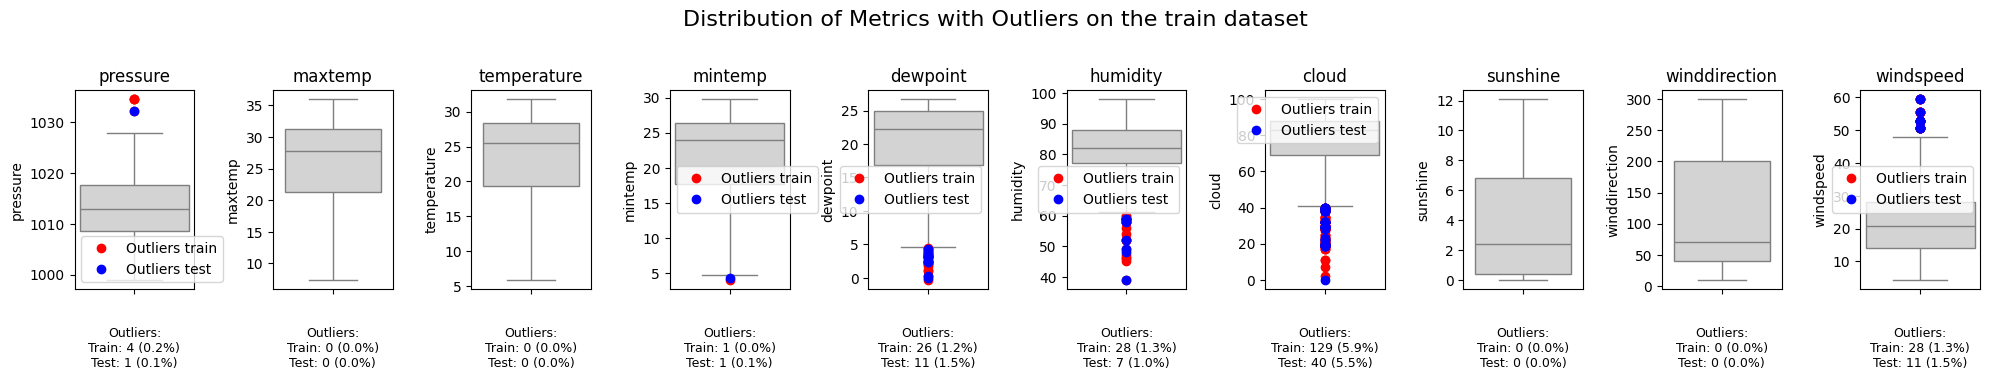

In [738]:
# Create a figure with 1 row and 10 columns
fig, axes = plt.subplots(1, 10, figsize=(20, 4))

# Add a main title to the whole figure
fig.suptitle('Distribution of Metrics with Outliers on the train dataset', fontsize=16, y=1.02)

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Get numeric columns
numeric_cols = df_combined_0.drop(columns=['id','day','dataset']).columns
   
# Create a boxplot for each column
for idx, (column, ax) in enumerate(zip(numeric_cols, axes)):
    # Create basic boxplot
    sns.boxplot(data=df_combined_0[column], ax=ax, color='lightgray', showfliers=False)

    # Calculate outliers
    Q1 = df_combined_0[column].quantile(0.25)
    Q3 = df_combined_0[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = (df_combined_0[column] < (Q1 - 1.5 * IQR)) | (df_combined_0[column] > (Q3 + 1.5 * IQR))
    
    # Plot outliers separately by dataset
    outliers_train = df_combined_0[outlier_mask & (df_combined_0['dataset'] == 'train')][column]
    outliers_test = df_combined_0[outlier_mask & (df_combined_0['dataset'] == 'test')][column]
    
    if len(outliers_train) > 0:
        ax.plot([0] * len(outliers_train), outliers_train, 'ro', label='Outliers train')
    if len(outliers_test) > 0:
        ax.plot([0] * len(outliers_test), outliers_test, 'bo', label='Outliers test')
    
    ax.set_title(column)
    ax.set_xlabel('')
    ax.tick_params(axis='y', rotation=0)
    
    # Add legend if there are outliers
    if len(outliers_train) > 0 or len(outliers_test) > 0:
        ax.legend()
    
    # Calculate percentages
    total_outliers = len(outliers_train) + len(outliers_test)
    total_train = len(df_combined_0[df_combined_0['dataset'] == 'train'])
    total_test = len(df_combined_0[df_combined_0['dataset'] == 'test'])
    
    # Add text below the plot
    stats_text = f"Outliers:\nTrain: {len(outliers_train)} ({len(outliers_train)/total_train*100:.1f}%)\nTest: {len(outliers_test)} ({len(outliers_test)/total_test*100:.1f}%)"
    ax.text(0.5, -0.3, stats_text, 
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes,
            fontsize=9)

plt.tight_layout()
plt.show()

As we can see there are quite a few outliers especially for the cloud metric. We will need to consider if we drop it or modify when we actually build our model since some models perform considerably worse with outliers.

Another observation is that there is no disproportionate representation of outliers in the train or in the test dataset, meaning the sets were most likely separated randomly instead of any engineered or deliberate split.

##### 2.2.6. Target label distribution
Finally let's check the distribution of the target label 'rainfall' 0 or 1 to see if there is an over-representation of one of the two classes.

In [739]:
# Checking the percentages of each target variable class in the train dataset
df_train_0['rainfall'].value_counts(normalize=True)

rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64

So we have about 3 times as many entries for rainfall (1) than no rainfall (0) with a 75-25 split. However, that is not enough to qualify this dataset as skewed or inbalanced.

#### 2.3. Advanced data exploration
##### 2.3.1. Data visualisations
Next we are going to create a number of visualizations to appreciate the distribution of the data and maybe draw some early observations as to what might influence rainfall or not. We will now focus on out train dataset since it is the one we will use for model building. We will also assess for multicolinearity, as it is a prerequisite (to avoid!) for model building. Finally we will get some ideas for feature engineering.

- 2.3.1.1. Mintemp, temperature and maxtemp

I am interested to see how these seemingly similar metric correlate. 

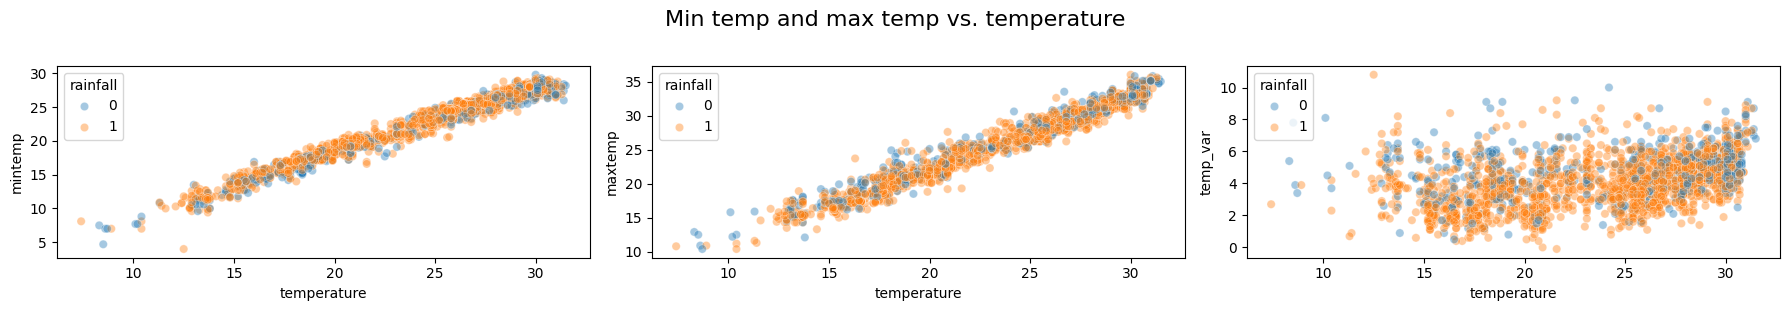

In [740]:
# Create a figure with 1 row and 10 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 3))

# Add a main title to the whole figure
fig.suptitle('Min temp and max temp vs. temperature', fontsize=16, y=1.02)

# Let's also create a metric with the total temperature variation on a given day": maxtemp - mintemp
df_train_0['temp_var'] = df_train_0['maxtemp'] - df_train_0['mintemp']

# Create scatterplot of `mintemp` versus `temperature`, comparing rainfall or not
sns.scatterplot(data=df_train_0, x='temperature', y='mintemp', hue='rainfall', alpha=0.4, ax = axes[0])
sns.scatterplot(data=df_train_0, x='temperature', y='maxtemp', hue='rainfall', alpha=0.4, ax = axes[1])
sns.scatterplot(data=df_train_0, x='temperature', y='temp_var', hue='rainfall', alpha=0.4, ax = axes[2])
plt.tight_layout()
plt.show()

* As we can see, mintemp, maxtemp and temperature seem to be highly positively correlated. We will likely not need to keep all three metrics. Furthermore, the distribution of the rainfall labels seems to be pretty uniform accross all possible temperatures, not leading to any conclusion of any obvious impact of the temperature on rainfall.

* A potentially interesting metric, the temperature change or total temperature delta during any given day (max minus min) does not seem to be correlated with the temperature. However, there also does not appear to be any obvious impact of this metric over the target metric.

- 2.3.1.2. Humidity, pressure and cloud coverage

These three factors are typically know to have an impact on weather and more specifically, on rainfall. Let's plot histograms to check the data distribution and the rainfall.

In [741]:
df_train_0.describe()

,id,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,temp_var
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425,4.195708
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116,1.525268
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000,-0.100000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000,3.100000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000,4.200000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000,5.200000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000,10.800000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


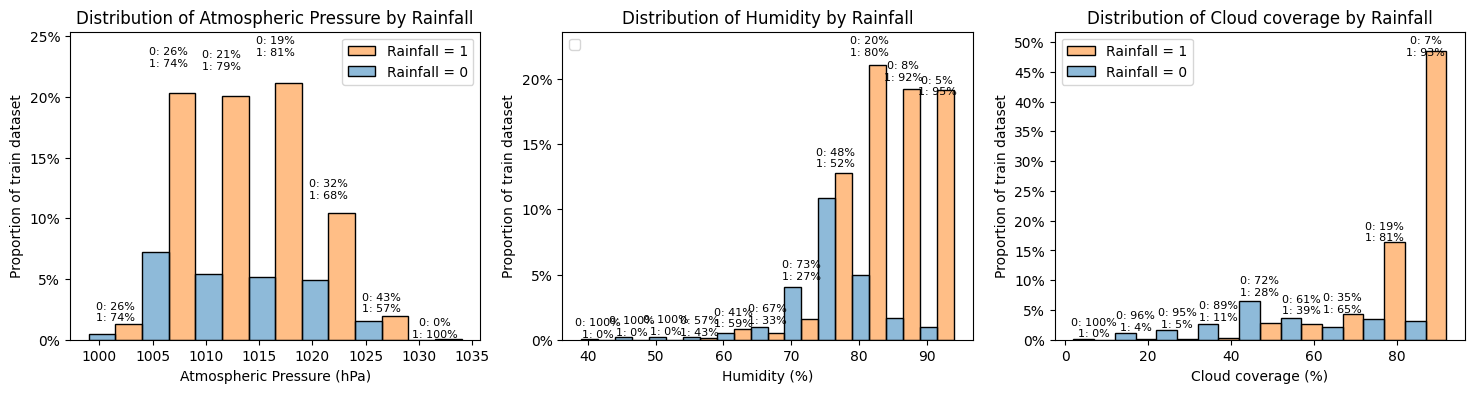

In [742]:
# Set figure and axes
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (18,4))

# Create histogram for pressure distibution and color by rainfall
sns.histplot(data=df_train_0, x='pressure', hue='rainfall',bins=np.arange(df_train_0['pressure'].min(),df_train_0['pressure'].max(),5), \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1,  ax=ax1)

# Add labels and title
ax1.set_xlabel('Atmospheric Pressure (hPa)')
ax1.set_ylabel('Proportion of train dataset')
ax1.set_title('Distribution of Atmospheric Pressure by Rainfall')
ax1.legend(['Rainfall = 1', 'Rainfall = 0'])

# Add percentage annotations for pressure histogram
bin_edges = np.arange(df_train_0['pressure'].min(), df_train_0['pressure'].max(),5)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
total_count_of_values= df_train_0['rainfall'].count()
max_y_abs_pressure = 0
for i, bin_center in enumerate(bin_centers):
    rainfall_0_count = (df_train_0['pressure'] >= bin_edges[i]) & (df_train_0['pressure'] < bin_edges[i+1]) & (df_train_0['rainfall']  == 0)
    rainfall_1_count = (df_train_0['pressure'] >= bin_edges[i]) & (df_train_0['pressure'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 1)
    total_count = rainfall_0_count.sum() + rainfall_1_count.sum()
    rainfall_0_percent = rainfall_0_count.sum() / total_count * 100
    rainfall_1_percent = rainfall_1_count.sum() / total_count * 100
    rainfall_0_percent_abs = rainfall_0_count.sum() / total_count_of_values * 100
    rainfall_1_percent_abs = rainfall_1_count.sum() / total_count_of_values * 100
    max_y = max(rainfall_0_percent_abs, rainfall_1_percent_abs)
    max_y_abs_pressure = max(max_y_abs_pressure, rainfall_0_percent_abs, rainfall_1_percent_abs)
    ax1.text(bin_center, 1.1*max_y/100, f"0: {rainfall_0_percent:.0f}%\n1: {rainfall_1_percent:.0f}%", ha="center", va="bottom", fontsize=8)   

ax1.set_ylim(0,max_y_abs_pressure*1.2/100)
ax1.set_yticks(np.arange(0, max_y_abs_pressure*1.2/100, 0.05))
ax1.set_yticklabels([f"{int(x*100)}%" for x in np.arange(0, max_y_abs_pressure*1.2/100, 0.05)])

# Create histogram for humidity distibution and color by rainfall
sns.histplot(data=df_train_0, x='humidity', hue='rainfall',bins=np.arange(df_train_0['humidity'].min(),df_train_0['humidity'].max(),5), \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1,  ax=ax2)

# Add labels and title
ax2.set_xlabel('Humidity (%)')
ax2.set_ylabel('Proportion of train dataset')
ax2.set_title('Distribution of Humidity by Rainfall')
ax2.legend(['Rainfall = 1', 'Rainfall = 0'])

# Add percentage annotations for pressure histogram
bin_edges = np.arange(df_train_0['humidity'].min(), df_train_0['humidity'].max(),5)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
total_count_of_values= df_train_0['rainfall'].count()
max_y_abs_humidity = 0
for i, bin_center in enumerate(bin_centers):
    rainfall_0_count = (df_train_0['humidity'] >= bin_edges[i]) & (df_train_0['humidity'] < bin_edges[i+1]) & (df_train_0['rainfall']  == 0)
    rainfall_1_count = (df_train_0['humidity'] >= bin_edges[i]) & (df_train_0['humidity'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 1)
    total_count = rainfall_0_count.sum() + rainfall_1_count.sum()
    rainfall_0_percent = rainfall_0_count.sum() / total_count * 100
    rainfall_1_percent = rainfall_1_count.sum() / total_count * 100
    rainfall_0_percent_abs = rainfall_0_count.sum() / total_count_of_values * 100
    rainfall_1_percent_abs = rainfall_1_count.sum() / total_count_of_values * 100
    max_y = max(rainfall_0_percent_abs, rainfall_1_percent_abs)
    max_y_abs_humidity = max(max_y_abs_humidity, rainfall_0_percent_abs, rainfall_1_percent_abs)
    ax2.text(bin_center, 1.1*max_y/100, f"0: {rainfall_0_percent:.0f}%\n1: {rainfall_1_percent:.0f}%", ha="center", va="bottom", fontsize=8)   

ax2.set_ylim(0,max_y_abs_humidity*1.2/100)
ax2.set_yticks(np.arange(0, max_y_abs_humidity*1.2/100, 0.05))
ax2.set_yticklabels([f"{int(x*100)}%" for x in np.arange(0, max_y_abs_humidity*1.2/100, 0.05)])
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1))

# Create histogram for cloud distibution and color by rainfall
sns.histplot(data=df_train_0, x='cloud', hue='rainfall',bins=np.arange(df_train_0['cloud'].min(),df_train_0['cloud'].max(),10), \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1,  ax=ax3)

# Add labels and title
ax3.set_xlabel('Cloud coverage (%)')
ax3.set_ylabel('Proportion of train dataset')
ax3.set_title('Distribution of Cloud coverage by Rainfall')
ax3.legend(['Rainfall = 1', 'Rainfall = 0'])

# Add percentage annotations for pressure histogram
bin_edges = np.arange(df_train_0['cloud'].min(), df_train_0['cloud'].max(),10)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
total_count_of_values= df_train_0['rainfall'].count()
max_y_abs_cloud = 0
for i, bin_center in enumerate(bin_centers):
    rainfall_0_count = (df_train_0['cloud'] >= bin_edges[i]) & (df_train_0['cloud'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 0)
    rainfall_1_count = (df_train_0['cloud'] >= bin_edges[i]) & (df_train_0['cloud'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 1)
    total_count = rainfall_0_count.sum() + rainfall_1_count.sum()
    rainfall_0_percent = rainfall_0_count.sum() / total_count * 100
    rainfall_1_percent = rainfall_1_count.sum() / total_count * 100
    rainfall_0_percent_abs = rainfall_0_count.sum() / total_count_of_values * 100
    rainfall_1_percent_abs = rainfall_1_count.sum() / total_count_of_values * 100
    max_y = max(rainfall_0_percent_abs, rainfall_1_percent_abs)
    max_y_abs_cloud = max(max_y_abs_cloud, rainfall_0_percent_abs, rainfall_1_percent_abs)
    ax3.text(bin_center, 1.1*max_y/100, f"0: {rainfall_0_percent:.0f}%\n1: {rainfall_1_percent:.0f}%", ha="center", va="bottom", fontsize=8)   

ax3.set_ylim(0,max_y_abs_cloud*1.2/100)
ax3.set_yticks(np.arange(0, max_y_abs_cloud*1.2/100, 0.05))
ax3.set_yticklabels([f"{int(x*100)}%" for x in np.arange(0, max_y_abs_cloud*1.2/100, 0.05)])
#ax3.legend(loc='upper left', bbox_to_anchor=(0, 1))

plt.show()

* The 'pressure' histogram above shows that the data is generally normally distributed. There also does not seem to be any obvious link between pressure and rainfall though the comparative percentage do seem to change a little at high pressures, with rainfall being comparatively less frequent at higher pressures (but there are also fewer data points).

* The humidity histogram show data skewed towards higher values of humidity. There also seem to be a correlation between higher values of humidity and increased chance of rainfall.

* Likewise, the cloud histogram show data skewed towards higher values of cloud coverage and there also seem to be a correlation between higher values of cloud coverage and increased chance of rainfall.

Let's check if cloud coverage and humidity look to be correlated.

- 2.3.1.3. Cloud and humidity

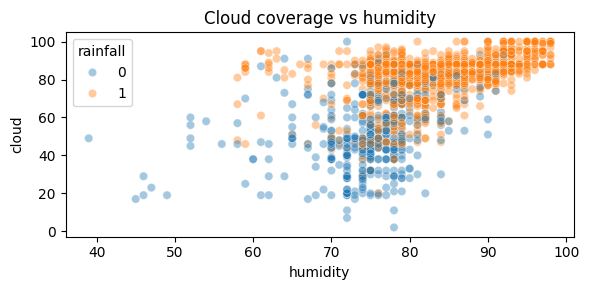

In [743]:
# Create a figure with 1 row and 10 columns
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Create scatterplot of `mintemp` versus `temperature`, comparing rainfall or not
sns.scatterplot(data=df_train_0, x='humidity', y='cloud', hue='rainfall', alpha=0.4)
plt.title('Cloud coverage vs humidity')
plt.tight_layout()
plt.show()

As shown on the scatterplot above, the correlation between cloud coverage and humidity is not strong but it is present, with higher values of humidity concurring with higher values of cloud coverage. As discussed before such higher value also seem to correlate with increased chance of rainfall.

- 2.3.1.4. Sunshine, Dewpoint, Windspeed and Winddirection

Let's build similar histograms for those 4 metrics that might have a less obvious correlation with rainfall.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


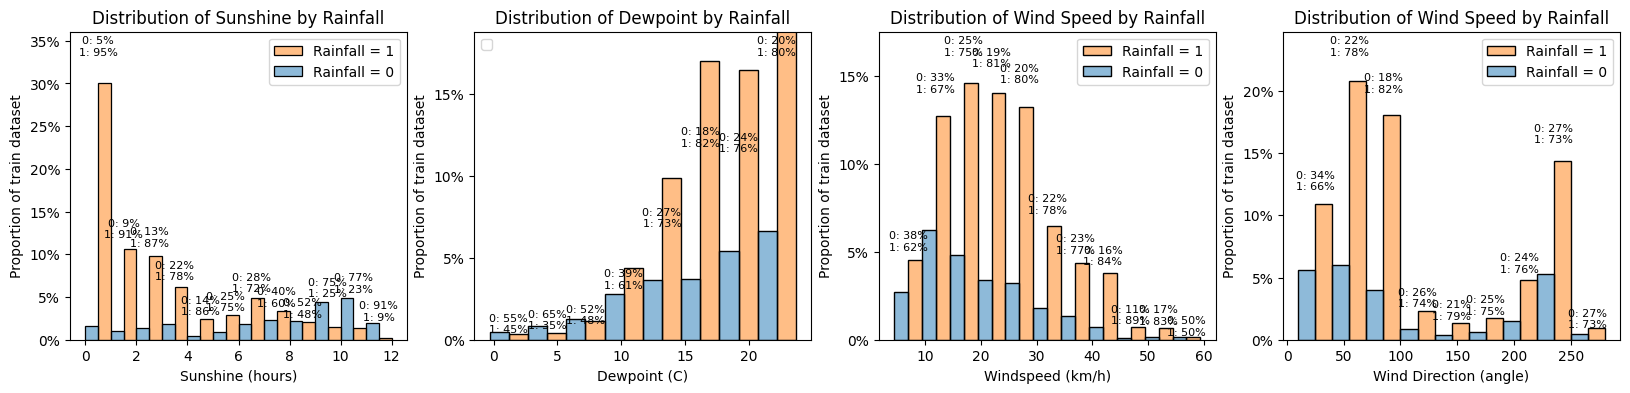

In [744]:
# Set figure and axes
fig, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,4))

# Create histogram for sunshine distfibution and color by rainfall
sns.histplot(data=df_train_0, x='sunshine', hue='rainfall',bins=np.arange(df_train_0['sunshine'].min(),df_train_0['sunshine'].max(),1), \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1,  ax=ax1)

# Add labels and title
ax1.set_xlabel('Sunshine (hours)')
ax1.set_ylabel('Proportion of train dataset')
ax1.set_title('Distribution of Sunshine by Rainfall')
ax1.legend(['Rainfall = 1', 'Rainfall = 0'])

# Add percentage annotations for sunshine histogram
bin_edges = np.arange(df_train_0['sunshine'].min(), df_train_0['sunshine'].max(),1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
total_count_of_values= df_train_0['rainfall'].count()
max_y_abs_sunshine = 0
for i, bin_center in enumerate(bin_centers):
    rainfall_0_count = (df_train_0['sunshine'] >= bin_edges[i]) & (df_train_0['sunshine'] < bin_edges[i+1]) & (df_train_0['rainfall']  == 0)
    rainfall_1_count = (df_train_0['sunshine'] >= bin_edges[i]) & (df_train_0['sunshine'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 1)
    total_count = rainfall_0_count.sum() + rainfall_1_count.sum()
    rainfall_0_percent = rainfall_0_count.sum() / total_count * 100
    rainfall_1_percent = rainfall_1_count.sum() / total_count * 100
    rainfall_0_percent_abs = rainfall_0_count.sum() / total_count_of_values * 100
    rainfall_1_percent_abs = rainfall_1_count.sum() / total_count_of_values * 100
    max_y = max(rainfall_0_percent_abs, rainfall_1_percent_abs)
    max_y_abs_sunshine = max(max_y_abs_sunshine, rainfall_0_percent_abs, rainfall_1_percent_abs)
    ax1.text(bin_center, 1.1*max_y/100, f"0: {rainfall_0_percent:.0f}%\n1: {rainfall_1_percent:.0f}%", ha="center", va="bottom", fontsize=8)   

ax1.set_ylim(0,max_y_abs_sunshine*1.2/100)
ax1.set_yticks(np.arange(0, max_y_abs_sunshine*1.2/100, 0.05))
ax1.set_yticklabels([f"{int(x*100)}%" for x in np.arange(0, max_y_abs_sunshine*1.2/100, 0.05)])

# Create histogram for dewpoint distibution and color by rainfall
sns.histplot(data=df_train_0, x='dewpoint', hue='rainfall',bins=np.arange(df_train_0['dewpoint'].min(),df_train_0['dewpoint'].max(),3), \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1,  ax=ax2)

# Add labels and title
ax2.set_xlabel('Dewpoint (C)')
ax2.set_ylabel('Proportion of train dataset')
ax2.set_title('Distribution of Dewpoint by Rainfall')
ax2.legend(['Rainfall = 1', 'Rainfall = 0'])

# Add percentage annotations for dewpoint histogram
bin_edges = np.arange(df_train_0['dewpoint'].min(), df_train_0['dewpoint'].max(),3)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
total_count_of_values= df_train_0['rainfall'].count()
max_y_abs_dewpoint = 0
for i, bin_center in enumerate(bin_centers):
    rainfall_0_count = (df_train_0['dewpoint'] >= bin_edges[i]) & (df_train_0['dewpoint'] < bin_edges[i+1]) & (df_train_0['rainfall']  == 0)
    rainfall_1_count = (df_train_0['dewpoint'] >= bin_edges[i]) & (df_train_0['dewpoint'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 1)
    total_count = rainfall_0_count.sum() + rainfall_1_count.sum()
    rainfall_0_percent = rainfall_0_count.sum() / total_count * 100
    rainfall_1_percent = rainfall_1_count.sum() / total_count * 100
    rainfall_0_percent_abs = rainfall_0_count.sum() / total_count_of_values * 100
    rainfall_1_percent_abs = rainfall_1_count.sum() / total_count_of_values * 100
    max_y = max(rainfall_0_percent_abs, rainfall_1_percent_abs)
    max_y_abs_dewpoint = max(max_y_abs_dewpoint, rainfall_0_percent_abs, rainfall_1_percent_abs)
    ax2.text(bin_center, 1.1*max_y/100, f"0: {rainfall_0_percent:.0f}%\n1: {rainfall_1_percent:.0f}%", ha="center", va="bottom", fontsize=8)   

ax2.set_ylim(0,max_y_abs_dewpoint*1.2/100)
ax2.set_yticks(np.arange(0, max_y_abs_dewpoint*1.2/100, 0.05))
ax2.set_yticklabels([f"{int(x*100)}%" for x in np.arange(0, max_y_abs_dewpoint*1.2/100, 0.05)])
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1))

# Create histogram for windspeed distibution and color by rainfall
sns.histplot(data=df_train_0, x='windspeed', hue='rainfall',bins=np.arange(df_train_0['windspeed'].min(),df_train_0['windspeed'].max(),5), \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1,  ax=ax3)

# Add labels and title
ax3.set_xlabel('Windspeed (km/h)')
ax3.set_ylabel('Proportion of train dataset')
ax3.set_title('Distribution of Wind Speed by Rainfall')
ax3.legend(['Rainfall = 1', 'Rainfall = 0'])

# Add percentage annotations for pressure histogram
bin_edges = np.arange(df_train_0['windspeed'].min(), df_train_0['windspeed'].max(),5)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
total_count_of_values= df_train_0['rainfall'].count()
max_y_abs_windspeed = 0
for i, bin_center in enumerate(bin_centers):
    rainfall_0_count = (df_train_0['windspeed'] >= bin_edges[i]) & (df_train_0['windspeed'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 0)
    rainfall_1_count = (df_train_0['windspeed'] >= bin_edges[i]) & (df_train_0['windspeed'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 1)
    total_count = rainfall_0_count.sum() + rainfall_1_count.sum()
    rainfall_0_percent = rainfall_0_count.sum() / total_count * 100
    rainfall_1_percent = rainfall_1_count.sum() / total_count * 100
    rainfall_0_percent_abs = rainfall_0_count.sum() / total_count_of_values * 100
    rainfall_1_percent_abs = rainfall_1_count.sum() / total_count_of_values * 100
    max_y = max(rainfall_0_percent_abs, rainfall_1_percent_abs)
    max_y_abs_windspeed = max(max_y_abs_windspeed, rainfall_0_percent_abs, rainfall_1_percent_abs)
    ax3.text(bin_center, 1.1*max_y/100, f"0: {rainfall_0_percent:.0f}%\n1: {rainfall_1_percent:.0f}%", ha="center", va="bottom", fontsize=8)   

ax3.set_ylim(0,max_y_abs_windspeed*1.2/100)
ax3.set_yticks(np.arange(0, max_y_abs_windspeed*1.2/100, 0.05))
ax3.set_yticklabels([f"{int(x*100)}%" for x in np.arange(0, max_y_abs_windspeed*1.2/100, 0.05)])

# Create histogram for winddirection distibution and color by rainfall
sns.histplot(data=df_train_0, x='winddirection', hue='rainfall',bins=np.arange(df_train_0['winddirection'].min(),df_train_0['winddirection'].max(),30), \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1,  ax=ax4)

# Add labels and title
ax4.set_xlabel('Wind Direction (angle)')
ax4.set_ylabel('Proportion of train dataset')
ax4.set_title('Distribution of Wind Speed by Rainfall')
ax4.legend(['Rainfall = 1', 'Rainfall = 0'])

# Add percentage annotations for pressure histogram
bin_edges = np.arange(df_train_0['winddirection'].min(), df_train_0['winddirection'].max(),30)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
total_count_of_values= df_train_0['rainfall'].count()
max_y_abs_winddirection = 0
for i, bin_center in enumerate(bin_centers):
    rainfall_0_count = (df_train_0['winddirection'] >= bin_edges[i]) & (df_train_0['winddirection'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 0)
    rainfall_1_count = (df_train_0['winddirection'] >= bin_edges[i]) & (df_train_0['winddirection'] < bin_edges[i+1]) & (df_train_0['rainfall'] == 1)
    total_count = rainfall_0_count.sum() + rainfall_1_count.sum()
    rainfall_0_percent = rainfall_0_count.sum() / total_count * 100
    rainfall_1_percent = rainfall_1_count.sum() / total_count * 100
    rainfall_0_percent_abs = rainfall_0_count.sum() / total_count_of_values * 100
    rainfall_1_percent_abs = rainfall_1_count.sum() / total_count_of_values * 100
    max_y = max(rainfall_0_percent_abs, rainfall_1_percent_abs)
    max_y_abs_winddirection = max(max_y_abs_winddirection, rainfall_0_percent_abs, rainfall_1_percent_abs)
    ax4.text(bin_center, 1.1*max_y/100, f"0: {rainfall_0_percent:.0f}%\n1: {rainfall_1_percent:.0f}%", ha="center", va="bottom", fontsize=8)   

ax4.set_ylim(0,max_y_abs_winddirection*1.2/100)
ax4.set_yticks(np.arange(0, max_y_abs_winddirection*1.2/100, 0.05))
ax4.set_yticklabels([f"{int(x*100)}%" for x in np.arange(0, max_y_abs_winddirection*1.2/100, 0.05)])

plt.show()

The following observation can be made based on the histograms above:

* Sunshine: as expected a lower amount of sunshine hours is correlated with a higher chance of rainfall. We will look below at the correlation between sunshine and cloud coverage.
* Dewpoint: the distribution of dewpoint is not normal but skewed to the right. Here we see there does not look to be any obvious correlation with rainfall though lower values of dewpoint seem to reduce the chance of rainfall (but there are fewer entries)
* Windspeed: the distribtuion is close to being normal though slightly skewed to the left. Here again, the correlation with rainfall is not obvious though stronger winds seem to increase the chance of rainfall. We could look to engineer a binary or categorical (and ordinal) feature with wind strength, taking example from the Beaufort scale (eg. light breeze for 6-11 km/h, moderate for 20-28 km/h etc.)
* Winddirection: the distribution is far from normal and it makes sense as we would expect the wind is mostly coming from some principal directions. We could reclassify the values in a categorical (but non-ordinal) feature with for example mostly east, mostly north, etc. However the proportions of rainfall do not seem to be correlated with wind direction.

- 2.3.1.5. Sunshine vs cloud
Let's check for correlation between sunshine hours and cloud coverage

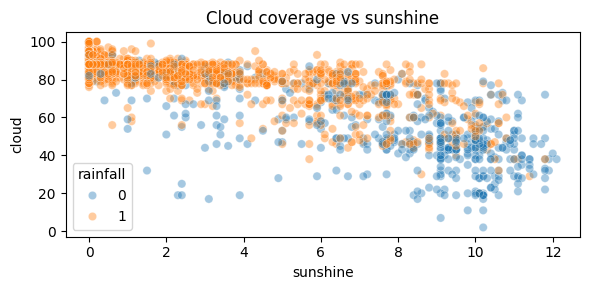

In [745]:
# Create a figure
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Create scatterplot of `cloud` versus `sunshine`, comparing rainfall or not
sns.scatterplot(data=df_train_0, x='sunshine', y='cloud', hue='rainfall', alpha=0.4)
plt.title('Cloud coverage vs sunshine')
plt.tight_layout()
plt.show()

The correlation is not perfect but there is (as expected) a negative correlation between sunshine hours and cloud coverage. As seen before, lower sunshine hours are correlated with higher cloud coverage and higher chance of rainfall.

- 2.3.1.6. Categorical windspeed and winddirection

Let's create categorical variables to deal with wind speed and direction. The highest windspeed is 59.5 km/h. According to the Beaufort scale, that is category 7 "moderate gale". Instead of creating 8 categories we can simplify a bit and arbitrarily create 4: 1 for under 5 km/h (cat 0 and 1 in Beaufort scale), 2 for 6-19 km/h, 3 for 20-38 km/h and 4 for 39-61 km/h.

For winddirection, we could create also 8 categories (N, NE, E, etc.) but will simplify and create 4: North (0) (0-45 and 315-360), East (1) (45-135), South (2) (135-225), West (3) (225-315)

In [746]:
# Reminder of min, max values of wind speed and direction
#df_combined_0[['windspeed','winddirection']].describe()

# Categorizing windspeed in 4 ordinal categories
df_train_0['windspeed_cat'] = pd.cut(df_train_0['windspeed'], bins=[-1, 5, 19, 38, 61], labels=[1, 2, 3, 4], ordered=True)

# Categorizing winddirection in 4 ordinal categories
df_train_0['winddirection_cat'] = pd.cut(df_train_0['winddirection'], bins=[-1, 45, 135, 225, 315, 361], labels=['North','East','South','West','North'], ordered = False)

Now let's plot again the histograms for wind but with the categories

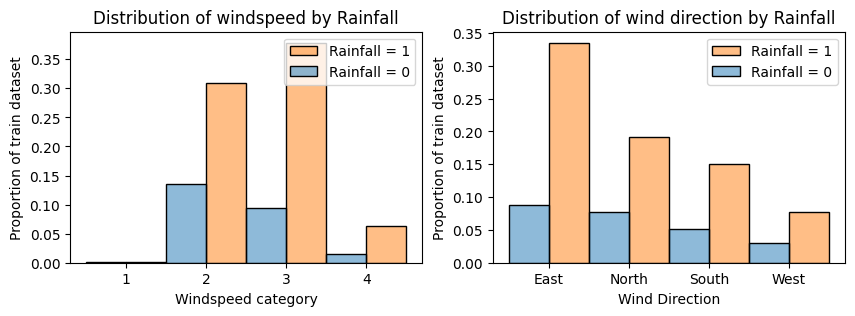

In [747]:
# Set figure and axes
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (10,3))

# Create histogram for windspeed_cat distribution and color by rainfall
sns.histplot(data=df_train_0, x='windspeed_cat', hue='rainfall', \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1,  ax=ax1)

# Add labels and title
ax1.set_xlabel('Windspeed category')
ax1.set_ylabel('Proportion of train dataset')
ax1.set_title('Distribution of windspeed by Rainfall')
ax1.legend(['Rainfall = 1', 'Rainfall = 0'])

# Create histogram for winddirection_cat distibution and color by rainfall
sns.histplot(data=df_train_0, x='winddirection_cat', hue='rainfall', \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1,  ax=ax2)

# Add labels and title
ax2.set_xlabel('Wind Direction')
ax2.set_ylabel('Proportion of train dataset')
ax2.set_title('Distribution of wind direction by Rainfall')
ax2.legend(['Rainfall = 1', 'Rainfall = 0'])

plt.show()

Converting continuous measures to categorical discrete ones can help to reduce the noise and draw better conclusions. Here we can see that:
- the windspeed does seem to be correlated with rainfall, with stronger category winds being correlated with higher probabilities of rainfall
- the wind direction does not seem to have much impact on the rainfall, with the proportions being very similar for dominant wind direction. The rainfall chance is slightly increased for easterly winds.

- 2.3.1.7. Day

Finally let's have a look at the dates. It is unlikely that there is more and less chance of rainfall depending on the day of the week. But it seems intuitive, even though we don't we don't know where the data was sampled, that there would be months of the year that are more prone to rainfall. Since there are 365 days in our dataset, we can assume day 1 is Jan 1st and can re-classify the days in months.

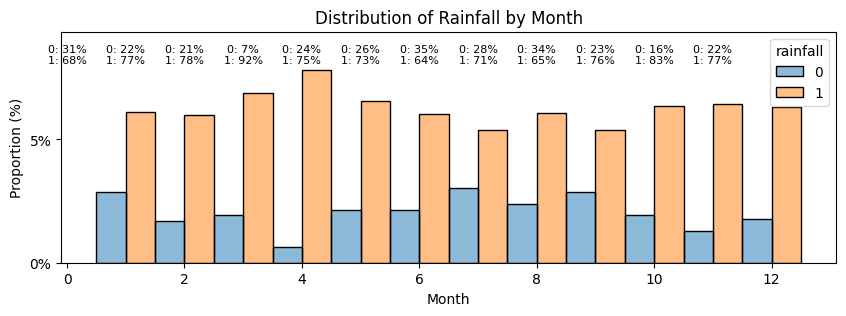

In [748]:
# Categorizing days in months
df_train_0['month'] = pd.cut(df_train_0['day'], \
                           bins=[-1, 31, 31+28, 31+28+31, 31+28+31+30, 31+28+31+30+31, 31+28+31+30+31+30, 31+28+31+30+31+30+31, 31+28+31+30+31+30+31+31,31+28+31+30+31+30+31+31+30,31+28+31+30+31+30+31+31+30+31,31+28+31+30+31+30+31+31+30+31+30,366], \
                           labels=[1,2,3,4,5,6,7,8,9,10,11,12], ordered=False)

# Set figure and axes
fig, ax = plt.subplots(1, 1, figsize = (10,3))

# Create histogram for month distribution and color by rainfall
sns.histplot(data=df_train_0, x='month', hue='rainfall', \
             stat='probability', kde=False, alpha=0.5, multiple = 'dodge',shrink=1)

# Add percentage annotations above each month
max_y_abs_month = 0
total_count_of_values = df_train_0['rainfall'].count()
for i, month in enumerate(df_train_0['month'].unique()):
    rainfall_0_count = (df_train_0['month'] == month) & (df_train_0['rainfall'] == 0)
    rainfall_1_count = (df_train_0['month'] == month) & (df_train_0['rainfall'] == 1)
    total_count = rainfall_0_count.sum() + rainfall_1_count.sum()
    rainfall_0_percent = int(rainfall_0_count.sum() / total_count * 100)
    rainfall_1_percent = int(rainfall_1_count.sum() / total_count * 100)
    ax.text(i, 0.08, f"0: {rainfall_0_percent}%\n1: {rainfall_1_percent}%", ha='center', va='bottom', fontsize=8)
    
    rainfall_0_percent_abs = rainfall_0_count.sum() / total_count_of_values * 100
    rainfall_1_percent_abs = rainfall_1_count.sum() / total_count_of_values * 100
    max_y_abs_month = max(max_y_abs_month, rainfall_0_percent_abs, rainfall_1_percent_abs)

ax.set_xlabel('Month')
ax.set_ylabel('Proportion (%)')
ax.set_title('Distribution of Rainfall by Month')

ax.set_ylim(0,max_y_abs_month*1.2/100)
ax.set_yticks(np.arange(0, max_y_abs_month*1.2/100, 0.05))
ax.set_yticklabels([f"{int(x*100)}%" for x in np.arange(0, max_y_abs_month*1.2/100, 0.05)])

plt.show()

As we can see there are some month of the year where rainfall is much more likely (April, November) and some where it is relatively less likely (January, July, September). We can probably use this feature as a predictor instead of the day feature.

##### 2.3.2. Correlation matrix
We have already analysed som inter-correlation between some of the features. Let's plot a correlation heatmap matrix to summarize and discuss our findings. We will include the engineered features of temp_var (max - min temperature), windspeed_cat and winddirection_cat. We can do a pre-selection of the features to already remove 'id', 'day' (and 'dataset'). 

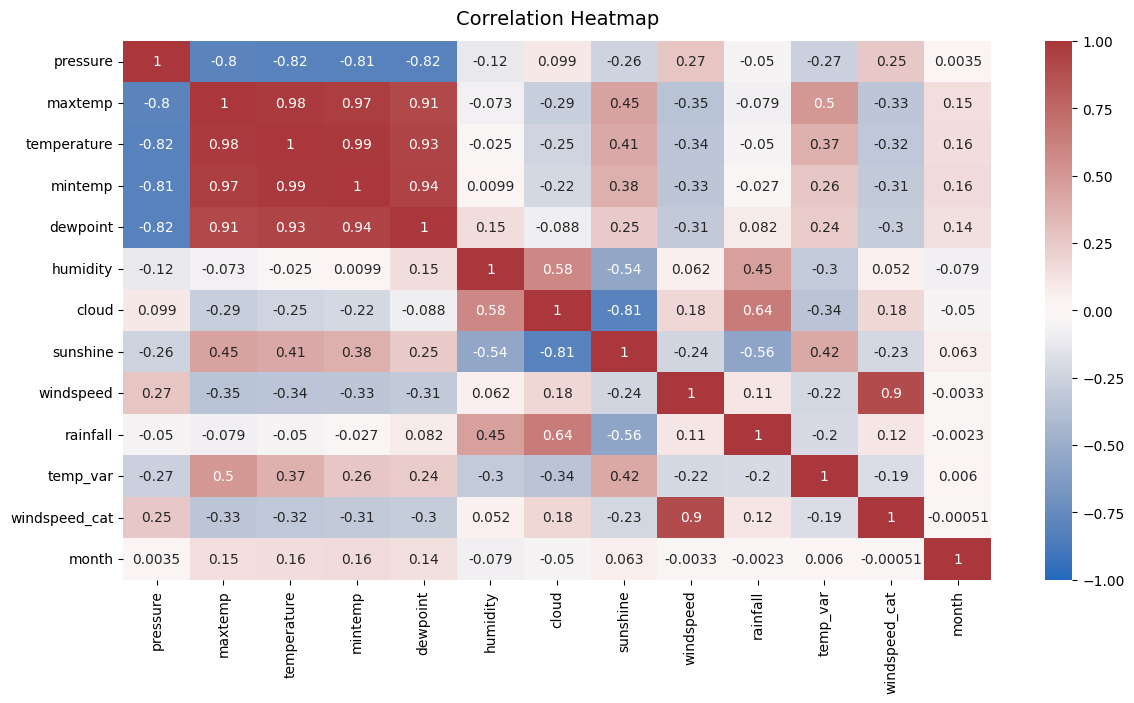

In [749]:
# Feature pre-selection (remove id, day and dataset):
df_train_1 = df_train_0.drop(columns=['id','day','dataset'] ,axis =1)

# Correlation cannot be plotted on non numerical values so we remove winddirection_cat. Also no need to include winddirection.
# Plot a correlation heatmap
plt.figure(figsize=(14, 7))
heatmap = sns.heatmap(df_train_1.drop(columns=['winddirection','winddirection_cat'] ,axis =1).corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

Insights
 - As discussed before, some of the metrics are correlated with on another: maxtemp, temperature, mintemp and dewpoint are all strongly correlated. To simplify the model we will likely only keep one feature of this group of 4.
 - Pressure is also strongly negatively correlated with this group of 4. We could look to drop it but for explanatory purposes, it could make sense to keep it.
 - There is also some moderate correlation between temperatures and sunshine though it is less strong.
 - As observed before, cloud coverage and humidy are moderately correlated. Sunshine and cloud are strongly (negatively) correlated. To simplify the model, we could look to keep one of the two. As cloud a marginally stronger correlation with rainfall than sunshine does, we could keep cloud. For explanatory purposes we could also look to keep both.
 - Obviously, windspeed_cat and windiection cat have strong correlation with the corresponding continuous variables. We will keep the engineered features.
 - Finally, looking at potentially strong predictors correlated with rainfall (among continuous variables), humidity, cloud and sunshine seem to be by far the strongest ones. We will keep all 3. Pressure, temperature and wind parameters seem to have a lesser correlation. We will simplify there.

 #### 2.4 Feature selection
 Before moving on to the modelling phase we need to select our final set of features and replicate the engineered features on our test dataset.
 We will keep the following set:
 - 'pressure'
 - 'temperature'
 - 'humidity'
 - 'cloud'
 - 'sunshine'
 - 'temp_var'
 - 'windspeed_cat'
 - 'winddirection_cat'
 - 'month'
 
and the target variable 'rainfall' for the train dataset.

In [750]:
# Creating the 'temp_var' feature for the test set: maxtemp - mintemp
df_test_0['temp_var'] = df_test_0['maxtemp'] - df_test_0['mintemp']

# Creating the windspeed_cat for the test test
df_test_0['windspeed_cat'] = pd.cut(df_test_0['windspeed'], bins=[-1, 5, 19, 38, 61], labels=[1, 2, 3, 4], ordered=True)

# Creating the winddirection_cat for the test test
df_test_0['winddirection_cat'] = pd.cut(df_test_0['winddirection'], bins=[-1, 45, 135, 225, 315, 361], labels=['North','East','South','West','North'], ordered = False)

# Creating the month for the test test
df_test_0['month'] = pd.cut(df_test_0['day'], \
                           bins=[-1, 31, 31+28, 31+28+31, 31+28+31+30, 31+28+31+30+31, 31+28+31+30+31+30, 31+28+31+30+31+30+31, 31+28+31+30+31+30+31+31,31+28+31+30+31+30+31+31+30,31+28+31+30+31+30+31+31+30+31,31+28+31+30+31+30+31+31+30+31+30,366], \
                           labels=[1,2,3,4,5,6,7,8,9,10,11,12], ordered=False)

# Removing the features not selected from the test dataset
df_test_2 = df_test_0.drop(columns=['id','day', 'maxtemp','mintemp','dewpoint','winddirection','windspeed','dataset'] ,axis=1)

# Removing the features not selected from the train dataset
df_train_2 = df_train_1.drop(columns=['maxtemp','mintemp','dewpoint','windspeed'] ,axis=1)

#### 2.5. Outliers treatment
Since we are using a logistic regression model and it is quite sensitive to outiliers wwe will need to remove the outliers. We need to check the outliers over the overall dataset though, not just the train one, but of course, we will only remove the outliers in the train section.

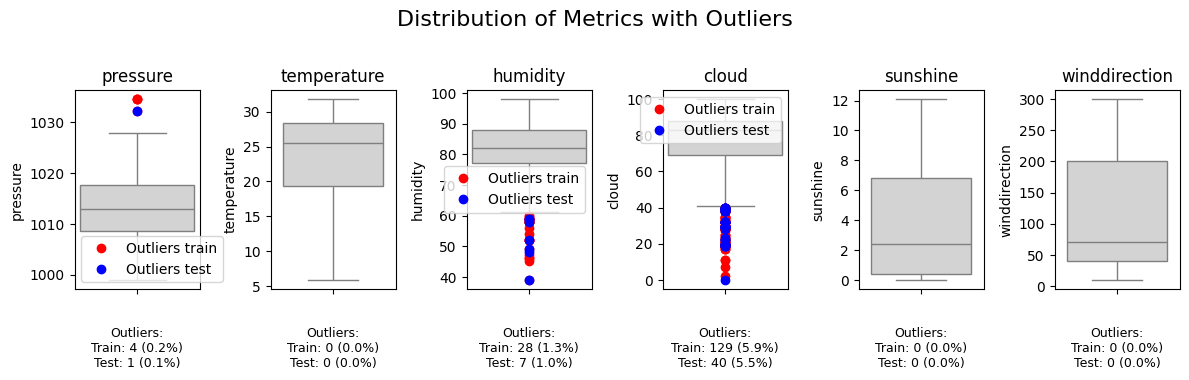

In [751]:
# Stack again the train and test dataet to calculate the outliers
# Add a column with the dataset origin
df_train_2['dataset'] = 'train'
df_test_2['dataset'] = 'test'

# Combine dataframes
df_combined_2 = pd.concat([df_train_2.drop(columns=['rainfall']), df_test_2],ignore_index=True)

# Create a figure with 1 row and 6 columns
fig, axes = plt.subplots(1, 6, figsize=(12, 4))

# Add a main title to the whole figure
fig.suptitle('Distribution of Metrics with Outliers', fontsize=16, y=1.02)

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Get numeric columns
numeric_cols = df_combined_2.drop(columns=['windspeed_cat','winddirection_cat','month','dataset']).columns
   
# Create a boxplot for each column
for idx, (column, ax) in enumerate(zip(numeric_cols, axes)):
    # Create basic boxplot
    sns.boxplot(data=df_combined_2[column], ax=ax, color='lightgray', showfliers=False)

    # Calculate outliers
    Q1 = df_combined_2[column].quantile(0.25)
    Q3 = df_combined_2[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = (df_combined_2[column] < (Q1 - 1.5 * IQR)) | (df_combined_2[column] > (Q3 + 1.5 * IQR))
    
    # Plot outliers separately by dataset
    outliers_train = df_combined_2[outlier_mask & (df_combined_2['dataset'] == 'train')][column]
    outliers_test = df_combined_2[outlier_mask & (df_combined_2['dataset'] == 'test')][column]
    
    if len(outliers_train) > 0:
        ax.plot([0] * len(outliers_train), outliers_train, 'ro', label='Outliers train')
    if len(outliers_test) > 0:
        ax.plot([0] * len(outliers_test), outliers_test, 'bo', label='Outliers test')
    
    ax.set_title(column)
    ax.set_xlabel('')
    ax.tick_params(axis='y', rotation=0)
    
    # Add legend if there are outliers
    if len(outliers_train) > 0 or len(outliers_test) > 0:
        ax.legend()
    
    # Calculate percentages
    total_outliers = len(outliers_train) + len(outliers_test)
    total_train = len(df_combined_2[df_combined_2['dataset'] == 'train'])
    total_test = len(df_combined_2[df_combined_2['dataset'] == 'test'])
    
    # Add text below the plot
    stats_text = f"Outliers:\nTrain: {len(outliers_train)} ({len(outliers_train)/total_train*100:.1f}%)\nTest: {len(outliers_test)} ({len(outliers_test)/total_test*100:.1f}%)"
    ax.text(0.5, -0.3, stats_text, 
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes,
            fontsize=9)

plt.tight_layout()
plt.show()

We need to remove rows in the train dataset that have outliers in any of the columns. That means the 'pressure', 'humidity', 'cloud' and 'temp_var' columns. We will keep this train dataset separately and try to train a model with the two dataframes, with and without outliers, and see how they perform.

In [752]:
# Outliers 'pressure'
Q1_pressure = df_combined_2['pressure'].quantile(0.25)
Q3_pressure = df_combined_2['pressure'].quantile(0.75)
IQR_pressure= Q3_pressure - Q1_pressure
outlier_pressure_mask = (df_combined_2['pressure'] < (Q1_pressure - 1.5 * IQR_pressure)) | (df_combined_2['pressure'] > (Q3_pressure + 1.5 * IQR_pressure))
df_combined_2['outlier_pressure'] = outlier_pressure_mask.astype(int)

# Outliers 'humidity'
Q1_humidity = df_combined_2['humidity'].quantile(0.25)
Q3_humidity = df_combined_2['humidity'].quantile(0.75)
IQR_humidity= Q3_humidity - Q1_humidity
outlier_humidity_mask = (df_combined_2['humidity'] < (Q1_humidity - 1.5 * IQR_humidity)) | (df_combined_2['humidity'] > (Q3_humidity + 1.5 * IQR_humidity))
df_combined_2['outlier_humidity'] = outlier_humidity_mask.astype(int)

# Outliers 'cloud'
Q1_cloud = df_combined_2['cloud'].quantile(0.25)
Q3_cloud = df_combined_2['cloud'].quantile(0.75)
IQR_cloud= Q3_cloud - Q1_cloud
outlier_cloud_mask = (df_combined_2['cloud'] < (Q1_cloud - 1.5 * IQR_cloud)) | (df_combined_2['cloud'] > (Q3_cloud + 1.5 * IQR_cloud))
df_combined_2['outlier_cloud'] = outlier_cloud_mask.astype(int)

# Outliers 'temp_var'
Q1_temp_var = df_combined_2['temp_var'].quantile(0.25)
Q3_temp_var = df_combined_2['temp_var'].quantile(0.75)
IQR_temp_var= Q3_temp_var - Q1_temp_var
outlier_temp_var_mask = (df_combined_2['temp_var'] < (Q1_temp_var - 1.5 * IQR_temp_var)) | (df_combined_2['temp_var'] > (Q3_temp_var + 1.5 * IQR_temp_var))
df_combined_2['outlier_temp_var'] = outlier_temp_var_mask.astype(int)

# Selecting the train dataset again
df_train_3 = df_combined_2[df_combined_2['dataset']=='train']

# Adding back the rainfall
df_train_3 = df_train_3.join(df_train_2[['rainfall']], how='left', on=df_train_3.index)


##### 2.6. Encoding
Next, we need to encode the non-numeric metrics. It's only windspeed_cat (which is ordinal, so it can stay like this) and winddirection_cat, which needs to be encoded as it is not ordinal. And we need to apply this encoding to the test dataset as well.

In [753]:
# Encode the categorical features on the train dataset
le = LabelEncoder()
df_train_3['wind_direction_enc'] = le.fit_transform(df_train_3['winddirection_cat'])

# Apply the same encoder on the test dataset
df_test_2['wind_direction_enc'] = le.fit_transform(df_test_2['winddirection_cat'])

# Create dummy variables for wind_direction on both datasets
wind_dir_dummies_train = pd.get_dummies(df_train_3['winddirection_cat'], prefix='wind_dir')
df_train_4 = pd.concat([df_train_3, wind_dir_dummies_train], axis=1)

wind_dir_dummies_test = pd.get_dummies(df_test_2['winddirection_cat'], prefix='wind_dir')
df_test_3 = pd.concat([df_test_2, wind_dir_dummies_test], axis=1)

In [754]:
# Keeping only the non-outlier values
df_train_4_no_outliers = df_train_4[(df_train_4['outlier_pressure']==0) & (df_train_4['outlier_humidity']==0) & (df_train_4['outlier_cloud']==0) & (df_train_4['outlier_temp_var']==0)]

# Cleaning up the train and test final dataframes
df_train_5 = df_train_4.drop(columns=['dataset','outlier_pressure','outlier_humidity','outlier_cloud','outlier_temp_var','winddirection','winddirection_cat','wind_direction_enc'],axis =1)
df_train_5_no_outliers = df_train_4_no_outliers.drop(columns=['dataset','outlier_pressure','outlier_humidity','outlier_cloud','outlier_temp_var','winddirection','winddirection_cat','wind_direction_enc'],axis =1)
df_test_4 = df_test_3.drop(columns = ['dataset','winddirection_cat','wind_direction_enc'],axis=1)

### 3. Model fitting
We are now (almost) ready to fit models. We have already a training and a testing dataset that are split. However, we will want to validate and calculate our model performance so we will further split our training dataset into a training and a validation dataset that we will hold out for performance evaluation.

#### 3.1. Data scaling
The last stage before fitting models to finish preprocessing the data is to scale the fields. Pressure, temperature, humidity all have values on very different scales. Although scaling is not absolutely necessary when fitting a Logistic Regression model, it is still recommended.

We will use StandardScaler as it is often the preferred choice for Logistic Regression as it centers the features at 0 and scales them to unit variance. We could also have used MinMaxScaler.

We do need to be careful with two things:
- the scaler fitted to the train the data should then be applied identically to the test data
- the ordinal metrics, windspeed_cat and month, does not need to be scaled

In [755]:
# Creating the features array X and the target array y
X = df_train_5.drop('rainfall', axis=1)
X_no_outliers = df_train_5_no_outliers.drop('rainfall', axis = 1).reset_index(drop=True)
y = df_train_5['rainfall']
y_no_outliers = df_train_5_no_outliers['rainfall'].reset_index(drop=True)

In [756]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['pressure', 'temperature', 'humidity','cloud','sunshine','temp_var']])
# Combine the scaled features with the ordinal 'wind_speed' feature
X_final = pd.DataFrame(X_scaled, columns=['pressure', 'temperature', 'humidity','cloud','sunshine','temp_var'])
X_final['windspeed_cat'] = X['windspeed_cat']
X_final['month'] = X['month']
X_final['wind_dir_East'] = X['wind_dir_East']
X_final['wind_dir_North'] = X['wind_dir_North']
X_final['wind_dir_South'] = X['wind_dir_South']
X_final['wind_dir_West'] = X['wind_dir_West']

df_test_scaled = scaler.fit_transform(df_test_4[['pressure', 'temperature', 'humidity','cloud','sunshine','temp_var']])

df_test = pd.DataFrame(df_test_scaled, columns=['pressure', 'temperature', 'humidity','cloud','sunshine','temp_var'])
df_test['windspeed_cat'] = df_test_4['windspeed_cat']
df_test['month'] = df_test_4['month']
df_test['wind_dir_East'] = df_test_4['wind_dir_East']
df_test['wind_dir_North'] = df_test_4['wind_dir_North']
df_test['wind_dir_South'] = df_test_4['wind_dir_South']
df_test['wind_dir_West'] = df_test_4['wind_dir_West']

In [757]:
# same for the no outliers model
scaler_no_outliers = StandardScaler()
X_scaled_no_outliers = scaler_no_outliers.fit_transform(X_no_outliers[['pressure', 'temperature', 'humidity','cloud','sunshine','temp_var']])
# Combine the scaled features with the ordinal 'wind_speed' feature
X_final_no_outliers = pd.DataFrame(X_scaled_no_outliers, columns=['pressure', 'temperature', 'humidity','cloud','sunshine','temp_var'])
X_final_no_outliers['windspeed_cat'] = X_no_outliers['windspeed_cat']
X_final_no_outliers['month'] = X_no_outliers['month']
X_final_no_outliers['wind_dir_East'] = X_no_outliers['wind_dir_East']
X_final_no_outliers['wind_dir_North'] = X_no_outliers['wind_dir_North']
X_final_no_outliers['wind_dir_South'] = X_no_outliers['wind_dir_South']
X_final_no_outliers['wind_dir_West'] = X_no_outliers['wind_dir_West']

df_test_scaled_no_outliers = scaler_no_outliers.fit_transform(df_test_4[['pressure', 'temperature', 'humidity','cloud','sunshine','temp_var']])

df_test_no_outliers = pd.DataFrame(df_test_scaled_no_outliers, columns=['pressure', 'temperature', 'humidity','cloud','sunshine','temp_var'])
df_test_no_outliers['windspeed_cat'] = df_test_4['windspeed_cat']
df_test_no_outliers['month'] = df_test_4['month']
df_test_no_outliers['wind_dir_East'] = df_test_4['wind_dir_East']
df_test_no_outliers['wind_dir_North'] = df_test_4['wind_dir_North']
df_test_no_outliers['wind_dir_South'] = df_test_4['wind_dir_South']
df_test_no_outliers['wind_dir_West'] = df_test_4['wind_dir_West']

To recap, we now have:
- X_final, y and df_test for the model that includes all training data (with outliers)
- X_final_no_outliers, y_no_outliers, df_test_no_outliers for the model without outliers
We will further split X_final, y on one hand and X_final_no_outliers, y_no_outliers on the other hand to have a train dataset and validation dataset.

#### 3.2. Train/validation splits

In [758]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42)
X_train_no_outliers, X_val_no_outliers, y_train_no_outliers, y_val_no_outliers = train_test_split(X_final_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

#### 3.3. Cross validation for regularization
Lastly, regularization can help prevent overfitting for the logistic regression model. We have two options:
- L1 (or Lasso): can be used but tends to provide sparse models. It can be useful when try to perform feature selection and identifying the most important features.
- L2 (or Ridge): is more commonly used for Logistic Regression as it adds a penalty term proportional to the square of the model coefficients.
To simplify, we will only try the no-regularization and the L2 regularizations options.

Furthermore, we have different possbilities for how to calibrate the Grid Search CV object and measure the performance. Here we are interested in the probabilities of rainfall, not just the binary output 0 or 1. We will therefore not measure performance and choose the best model according to the roc_auc_score, but rather the 'neg_log_loss' (negative log-loss), which measures the cross-entropy between the true labels and the predicted probabilities. The lower the log-loss, the better the model's ability to produce accurate probabilities.

In [759]:
# Define the parameter grid for cross-validation
param_grid = {
    'penalty': ['none', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100]
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42,  solver='lbfgs'),
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=cv,
    n_jobs=-1
)

#### 3.4. Model fitting and evaluation
##### 3.4.1. with outliers

In [760]:
def get_model_performance(stage_name:str, model, X, y):
    """
    Calculates and returns the performance metrics for a given model and data.

    Parameters:
    model (sklearn model): The trained model.
    X (numpy array or pandas DataFrame): The input features.
    y (numpy array or pandas Series): The target variable.

    Returns:
    pandas DataFrame: A DataFrame with the performance metrics.
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_prob)
    neg_log_loss = -model.score(X, y)

    # Get the model parameters
    if hasattr(model, 'penalty'):
        penalty = model.penalty
    else:
        penalty = 'none'

    if hasattr(model, 'C'):
        C = model.C
    else:
        C = None

    performance_metrics = pd.DataFrame({
        'stage': [stage_name],
        'penalty': [penalty],
        'C': [C],
        'accuracy': [accuracy],
        'recall': [recall],
        'precision': [precision],
        'f1': [f1],
        'roc_auc': [roc_auc],
        'neg_log_loss': [-neg_log_loss]
    })

    return performance_metrics

In [761]:
# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the training performance metrics for the best model
best_model_with_outliers = grid_search.best_estimator_
train_performance_df = get_model_performance('Logistic Regression (with outliers) - Train performance' ,best_model_with_outliers, X_train, y_train)

# Get the validation performance metrics for the best model
validation_performance_df = get_model_performance('Logistic Regression (with outliers) - Validation performance' ,best_model_with_outliers, X_val, y_val)

performance_df = pd.concat([train_performance_df,validation_performance_df])
performance_df

c:\Users\tklein2\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,stage,penalty,C,accuracy,recall,precision,f1,roc_auc,neg_log_loss
0,Logistic Regression (with outliers) - Train pe...,l2,0.1,0.867580,0.942149,0.889993,0.915328,0.902427,0.867580
0,Logistic Regression (with outliers) - Validati...,l2,0.1,0.856164,0.949843,0.865714,0.905830,0.868865,0.856164


##### 3.4.2. Without outliers

In [762]:
# Fit the GridSearchCV object
grid_search.fit(X_train_no_outliers, y_train_no_outliers)

# Get the training performance metrics for the best model
best_model_no_outliers = grid_search.best_estimator_
train_performance_df_no_outliers = get_model_performance('Logistic Regression (no outliers) - Train performance' ,best_model_no_outliers, X_train_no_outliers, y_train_no_outliers)

In [763]:
# Get the validation performance metrics for the best model
validation_performance_df_no_outliers = get_model_performance('Logistic Regression (no outliers) - Validation performance' ,best_model_with_outliers, X_val_no_outliers, y_val_no_outliers)

performance_df = pd.concat([performance_df,train_performance_df_no_outliers,validation_performance_df_no_outliers])
performance_df

,stage,penalty,C,accuracy,recall,precision,f1,roc_auc,neg_log_loss
0,Logistic Regression (with outliers) - Train pe...,l2,0.1,0.867580,0.942149,0.889993,0.915328,0.902427,0.867580
0,Logistic Regression (with outliers) - Validati...,l2,0.1,0.856164,0.949843,0.865714,0.905830,0.868865,0.856164
0,Logistic Regression (no outliers) - Train perf...,l2,0.1,0.860062,0.948462,0.885776,0.916048,0.876471,0.860062
0,Logistic Regression (no outliers) - Validation...,l2,0.1,0.863861,0.930159,0.898773,0.914197,0.852256,0.863861


Looking at the results above we can see that:
- in both cases the validation scores are slightly lower than the testing ones. Only slightly though, so there is no need to worry
- there is no significant difference between using the dataset with outliers or the one without. The neg_log_loss is acutally slightly lower (so better) with the outliers and so is the roc_auc score.
We will continue and decide to keep the model with outliers for simplicity and to cover a wider range of values. Before making the final predictions on the test dataset, using the best_model_with_outliers, we will look at three final summaries: confusion matrix, roc_auc_curve and classification report.

##### 3.4.3. Confusion matrix
Let's display the confusion matrix using the validation dataset.


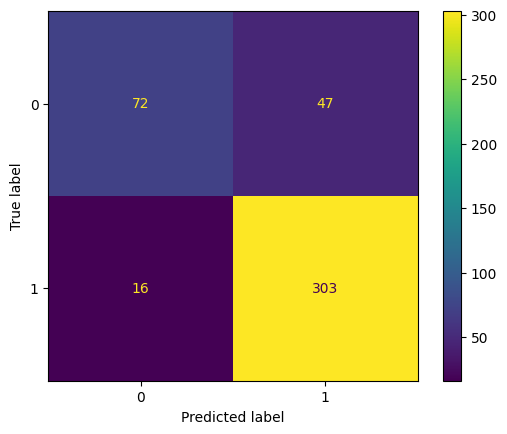

In [764]:
# Use the logistic regression model to get predictions on the validation set
y_pred = best_model_with_outliers.predict(X_val)

# Compute values for confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=best_model_with_outliers.classes_)

# Create display of confusion matrix
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=best_model_with_outliers.classes_)
# Plot confusion matrix
cm_disp.plot(values_format='')

# Display plot
plt.show()

In [765]:
df_train_0['rainfall'].value_counts(normalize=True)

rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64

This shows that the model does seem to predict quite a few false positives (47 days where it did not rain but was predicted to rain) but considerably less false negatives (16 days where it was predicted to rain but it didn't) considering the split of the data being 75%-25% rainfall days vs. non-rainfall days. The model seems to be pretty good at predicting rainfall but less so as predicting no rainfall. Let's confirm that with the classification report.

##### 3.4.4. Classification report

In [766]:
# Create classification report for logistic regression model
target_names = ['Predicted no rainfall', 'Predicted rainfall']
print(classification_report(y_val, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

Predicted no rainfall       0.82      0.61      0.70       119
   Predicted rainfall       0.87      0.95      0.91       319

             accuracy                           0.86       438
            macro avg       0.84      0.78      0.80       438
         weighted avg       0.85      0.86      0.85       438



The classificaiton report shows that the model we went with achieved a precision of 85%, recall of 86%, f1-score of 85% and accuracy of 86%. These are all pretty  good scores. The difference in metrics between predicted rainfall and predicted no rainfall do confirm that the model is better at predicting rainfall than the absence of it.

##### 3.4.5. Roc-Auc curve
Finally let's calculate predicition probabilities on the validation dataset using our model and display the roc-auc curve. The roc_curve() function is used to compute the false positive rate (FPR) and true positive rate (TPR) at various threshold settings. The auc() function is then used to calculate the area under the ROC curve (ROC-AUC), which is a measure of the model's discriminative ability.

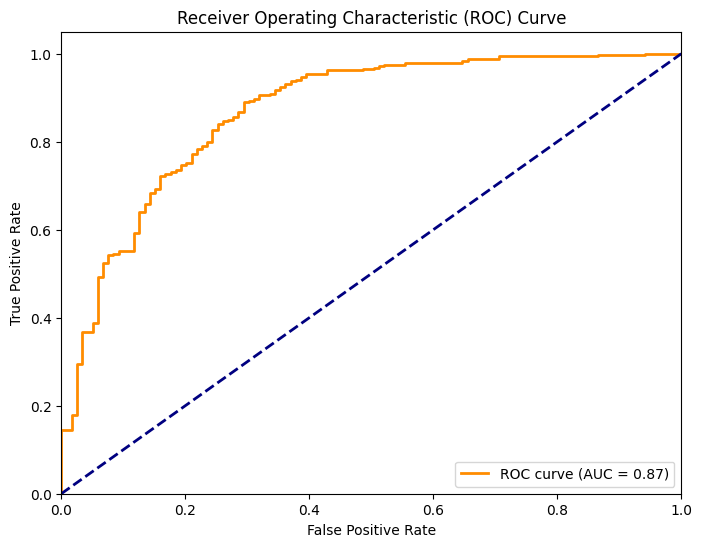

In [767]:
# Make probability predictions on the validation set
y_prob = best_model_with_outliers.predict_proba(X_val)[:, 1]

# ROC-AUC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.show()

As we can see, the model is much better than a random guessing one (blue line) but the ideal model would have an even sharper curve in the beginning. This chart confirms our observation from before that our model is not perfect to limit false positives.

### 4. Predicting on the test set

After all this work we can go ahead and use our model to predict on the test dataset. It is not a perfect model but it is pretty good for now. We could (and should) iterate with adding or removing some features and engineering some new ones. For now we will use it to predict on the left out test dataset.

In [768]:
# Predicting on the test dataset
y_pred = best_model_with_outliers.predict(df_test)
y_prob = best_model_with_outliers.predict_proba(df_test)[:, 1]
df_test['predicted_outcome'] = y_pred
df_test['rainfall'] = y_prob
df_test.head()

,pressure,temperature,humidity,cloud,sunshine,temp_var,windspeed_cat,month,wind_dir_East,wind_dir_North,wind_dir_South,wind_dir_West,predicted_outcome,rainfall
0,1.089945,-1.547695,1.706070,1.263248,-1.007591,0.334189,3,1,True,False,False,False,1,0.975124
1,0.544699,-1.414980,1.834056,1.263248,-1.007591,-1.592121,3,1,True,False,False,False,1,0.980034
2,1.889640,-2.571492,0.426211,1.095855,-1.007591,-1.529982,2,1,False,True,False,False,1,0.902064
3,1.707891,-1.263307,-0.981635,-1.749836,0.944687,0.707023,4,1,False,True,False,False,0,0.136512
4,1.580667,-1.926879,-1.877537,-1.526645,1.522121,3.379000,3,1,False,True,False,False,0,0.059280


In [775]:
# Adding back the original index, keeping only the id and probability columns, round to one decimal place and exporting
df_test['id'] = list(range(2190,len(df_test)+2190))
final_submission = df_test[['id','rainfall']]
final_submission['rainfall']=df_test['rainfall'].round(1)
final_submission.head()

,id,rainfall
0,2190,1.0
1,2191,1.0
2,2192,0.9
3,2193,0.1
4,2194,0.1


In [778]:
# Exporting
final_submission.to_csv('submission_rainfall.csv',index=False)

### 5. Bonus - Relative feature importance

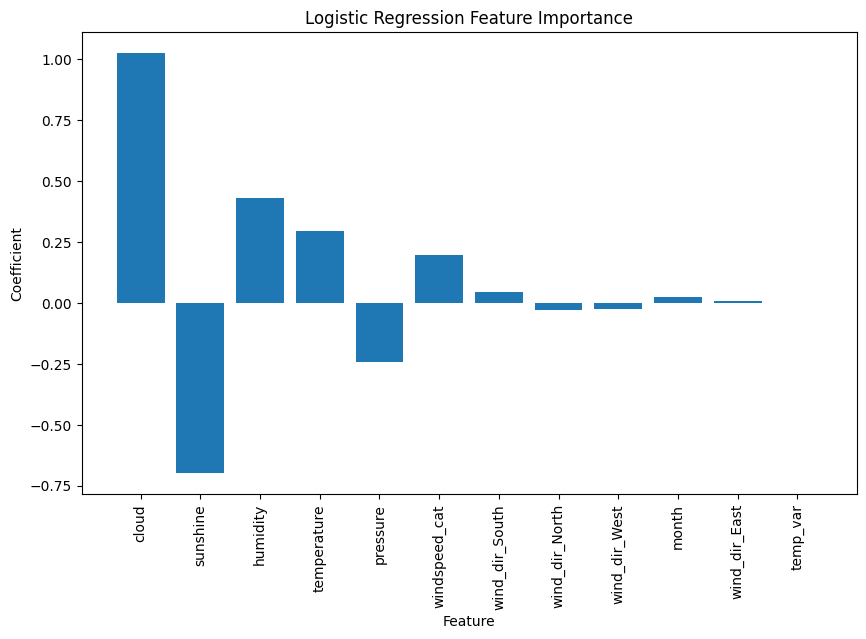

In [779]:
# Get the feature names
feature_names = X_val.columns

# Get the model coefficients
coefficients = best_model_with_outliers.coef_[0]

# Create a DataFrame with the feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of the coefficients
feature_importance = feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)

# Plot the feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(feature_importance['Feature'], feature_importance['Coefficient'])
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient')
ax.set_title('Logistic Regression Feature Importance')
ax.tick_params(axis='x', rotation=90)
plt.show()